# Preprocessing

### Importing Libraries and Data

In [1070]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

In [1071]:
df_weekly = nfl.import_weekly_data([2019, 2020, 2021, 2022, 2023, 2024])
df_draft = nfl.import_draft_picks(list(range(1994, 2024)))
df_schedule = nfl.import_schedules([2019, 2020, 2021, 2022, 2023, 2024])

df_weekly = df_weekly[df_weekly['season_type'] == 'REG']

Downcasting floats.


In [1072]:
df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']
df_draft = df_draft.rename(columns={'gsis_id': 'player_id'})

In [1073]:
df_merged = pd.melt(
    df_weekly,
    id_vars=['player_id', 'player_name', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id'
)

In [1074]:
df_merged = pd.merge(df_merged[['player_id', 'player_name', 'position', 'season', 'week', 'game_id', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points']], df_draft[['player_id', 'pick']], on = 'player_id', how = 'left')
df_merged = pd.merge(df_merged, df_schedule[['game_id', 'home_team', 'roof', 'surface', 'wind', 'temp']], on='game_id', how='inner')

df_merged = df_merged.drop(columns='game_id')


### Data exploration

In [1075]:
df_merged.columns

Index(['player_id', 'player_name', 'position', 'season', 'week', 'recent_team',
       'opponent_team', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'passing_2pt_conversions', 'interceptions',
       'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds',
       'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions',
       'targets', 'receiving_yards', 'receiving_tds',
       'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points',
       'pick', 'home_team', 'roof', 'surface', 'wind', 'temp'],
      dtype='object')

In [1076]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30513 entries, 0 to 30512
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  30513 non-null  object 
 1   player_name                30513 non-null  object 
 2   position                   30513 non-null  object 
 3   season                     30513 non-null  int32  
 4   week                       30513 non-null  int32  
 5   recent_team                30513 non-null  object 
 6   opponent_team              30513 non-null  object 
 7   completions                30513 non-null  int32  
 8   attempts                   30513 non-null  int32  
 9   passing_yards              30513 non-null  float32
 10  passing_tds                30513 non-null  int32  
 11  passing_2pt_conversions    30513 non-null  int32  
 12  interceptions              30513 non-null  float32
 13  sack_fumbles_lost          30513 non-null  int

In [1077]:
df_merged.head()

,player_id,player_name,position,season,week,recent_team,opponent_team,completions,attempts,passing_yards,...,receiving_tds,receiving_2pt_conversions,receiving_fumbles_lost,fantasy_points,pick,home_team,roof,surface,wind,temp
0,00-0019596,T.Brady,QB,2019,2,NE,MIA,20,28,264.0,...,0,0,0.0,24.66,199.0,MIA,outdoors,grass,4.0,87.0
1,00-0019596,T.Brady,QB,2019,4,NE,BUF,18,39,150.0,...,0,0,0.0,3.70,199.0,BUF,outdoors,astroturf,10.0,58.0
2,00-0019596,T.Brady,QB,2019,5,NE,WAS,28,42,348.0,...,0,0,0.0,23.92,199.0,WAS,outdoors,grass,8.0,70.0
3,00-0019596,T.Brady,QB,2019,7,NE,NYJ,31,45,249.0,...,0,0,0.0,11.96,199.0,NYJ,outdoors,fieldturf,0.0,58.0
4,00-0019596,T.Brady,QB,2019,9,NE,BAL,30,46,285.0,...,0,0,0.0,13.40,199.0,BAL,outdoors,grass,1.0,48.0


In [1078]:
df_merged.isnull().sum()

player_id                        0
player_name                      0
position                         0
season                           0
week                             0
recent_team                      0
opponent_team                    0
completions                      0
attempts                         0
passing_yards                    0
passing_tds                      0
passing_2pt_conversions          0
interceptions                    0
sack_fumbles_lost                0
carries                          0
rushing_yards                    0
rushing_tds                      0
rushing_2pt_conversions          0
rushing_fumbles_lost             0
receptions                       0
targets                          0
receiving_yards                  0
receiving_tds                    0
receiving_2pt_conversions        0
receiving_fumbles_lost           0
fantasy_points                   0
pick                          6851
home_team                        0
roof                

### Feature Engineering

In [1079]:
print(df_merged[df_merged['pick'].isna()])

        player_id player_name position  season  week recent_team  \
105    00-0025708     M.Moore       QB    2019     1          KC   
106    00-0025708     M.Moore       QB    2019     7          KC   
107    00-0025708     M.Moore       QB    2019    16          KC   
108    00-0026035  D.Amendola       WR    2019     1         DET   
109    00-0026035  D.Amendola       WR    2019     3         DET   
...           ...         ...      ...     ...   ...         ...   
30508  00-0039921    T.Benson       RB    2024     4         ARI   
30509  00-0039921    T.Benson       RB    2024     9         ARI   
30510  00-0039921    T.Benson       RB    2024    10         ARI   
30511  00-0039921    T.Benson       RB    2024    14         ARI   
30512  00-0039921    T.Benson       RB    2024    15         ARI   

      opponent_team  completions  attempts  passing_yards  ...  receiving_tds  \
105             JAX            0         1            0.0  ...              0   
106             DEN  

In [1080]:
df_merged['pick'] = df_merged['pick'].fillna(260)

In [1081]:
df_merged['wind'] = df_merged.groupby(['home_team', 'week'])['wind'].transform(lambda x: x.fillna(x.mean()))
df_merged['temp'] = df_merged.groupby(['home_team', 'week'])['temp'].transform(lambda x: x.fillna(x.mean()))
df_merged['wind'] = df_merged['wind'].fillna(df_merged['wind'].median())
df_merged['temp'] = df_merged['temp'].fillna(df_merged['temp'].median())

In [1082]:
df_merged['surface'] = df_merged['surface'].fillna('unknown')

In [1083]:
df_merged['turnover'] = (
    df_merged['interceptions'] +
    df_merged['sack_fumbles_lost'] +
    df_merged['rushing_fumbles_lost'] +
    df_merged['receiving_fumbles_lost']
)

df_merged = df_merged.drop(columns=['interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost'])

In [1084]:
df_merged['rushing_pts'] = (df_merged['rushing_tds'] * 6) + (df_merged['rushing_2pt_conversions'] * 2)
df_merged['receiving_pts'] = (df_merged['receiving_tds'] * 6) + (df_merged['receiving_2pt_conversions'] * 2)
df_merged['passing_pts'] = (df_merged['passing_tds'] * 6) + (df_merged['passing_2pt_conversions'] * 2)

df_merged = df_merged.drop(columns=['rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 'passing_2pt_conversions'])

In [1085]:
# Spalten, für die die EWM-Werte berechnet werden sollen
ewm_columns = ['completions', 'attempts', 'passing_yards', 'carries',
               'rushing_yards', 'receptions', 'targets', 'receiving_yards',
               'fantasy_points', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts']

# Sortieren der Daten nach player_id, season und week
df_merged = df_merged.sort_values(by=['player_id', 'season', 'week'])

# Funktion, um die EWM-Werte für jede Gruppe (pro Spieler) zu berechnen
def calculate_ewm_features(group, columns, alpha=0.5):
    ewm_result = pd.DataFrame(index=group.index)
    
    for col in columns:
        # Temporärer Platzhalter für die berechneten EWM-Werte
        temp_ewm = []
        # Iteration durch jede Zeile der Gruppe
        for i in range(len(group)):
            # Subset der Daten bis zur vorherigen Woche
            historical_data = group.iloc[:i]
            # EWM nur auf historische Daten anwenden
            temp_ewm.append(historical_data[col].ewm(alpha=alpha).mean().iloc[-1] if not historical_data.empty else np.nan)
        # Ergebnis hinzufügen
        ewm_result[f'ewm_{col}'] = temp_ewm
    
    return pd.concat([group.reset_index(drop=True), ewm_result.reset_index(drop=True)], axis=1)


# EWM-Werte für jede Spielergruppe berechnen
df_merged = df_merged.groupby('player_id').apply(calculate_ewm_features, columns=ewm_columns).reset_index(drop=True)

/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_20557/118051308.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby('player_id').apply(calculate_ewm_features, columns=ewm_columns).reset_index(drop=True)


In [1086]:
df_merged.isnull().sum()

player_id                 0
player_name               0
position                  0
season                    0
week                      0
recent_team               0
opponent_team             0
completions               0
attempts                  0
passing_yards             0
carries                   0
rushing_yards             0
receptions                0
targets                   0
receiving_yards           0
fantasy_points            0
pick                      0
home_team                 0
roof                      0
surface                   0
wind                      0
temp                      0
turnover                  0
rushing_pts               0
receiving_pts             0
passing_pts               0
ewm_completions        1322
ewm_attempts           1322
ewm_passing_yards      1322
ewm_carries            1322
ewm_rushing_yards      1322
ewm_receptions         1322
ewm_targets            1322
ewm_receiving_yards    1322
ewm_fantasy_points     1322
ewm_turnover        

In [1087]:
df_merged['player_id'].nunique()

1322

In [1088]:
df_merged[[col for col in df_merged.columns if col.startswith('ewm')]] = df_merged[[col for col in df_merged.columns if col.startswith('ewm')]].fillna(0)

In [1089]:
# Ausgabe der neuen Spalten
df_merged[['player_id', 'season', 'week', 'ewm_passing_yards', 'passing_yards', 'ewm_rushing_yards', 'rushing_yards', 'fantasy_points']]

,player_id,season,week,ewm_passing_yards,passing_yards,ewm_rushing_yards,rushing_yards,fantasy_points
0,00-0019596,2019,1,0.000000,341.0,0.000000,0.0,25.639999
1,00-0019596,2019,2,341.000000,264.0,0.000000,1.0,24.660000
2,00-0019596,2019,3,289.666667,306.0,0.666667,-1.0,20.139999
3,00-0019596,2019,4,299.000000,150.0,-0.285714,-3.0,3.700000
4,00-0019596,2019,5,219.533333,348.0,-1.733333,0.0,23.920000
...,...,...,...,...,...,...,...,...
30508,00-0039921,2024,10,0.000000,0.0,28.102362,62.0,8.700000
30509,00-0039921,2024,12,0.000000,0.0,45.117647,18.0,1.800000
30510,00-0039921,2024,13,0.000000,0.0,31.532290,20.0,2.000000
30511,00-0039921,2024,14,0.000000,0.0,25.760508,15.0,1.900000


In [1090]:
df_merged = df_merged.drop(columns=['completions', 'attempts', 'passing_yards', 'carries', 'rushing_yards', 'receptions', 'targets', 
                                    'receiving_yards', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts'])

In [1091]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30513 entries, 0 to 30512
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            30513 non-null  object 
 1   player_name          30513 non-null  object 
 2   position             30513 non-null  object 
 3   season               30513 non-null  int32  
 4   week                 30513 non-null  int32  
 5   recent_team          30513 non-null  object 
 6   opponent_team        30513 non-null  object 
 7   fantasy_points       30513 non-null  float32
 8   pick                 30513 non-null  float64
 9   home_team            30513 non-null  object 
 10  roof                 30513 non-null  object 
 11  surface              30513 non-null  object 
 12  wind                 30513 non-null  float64
 13  temp                 30513 non-null  float64
 14  ewm_completions      30513 non-null  float64
 15  ewm_attempts         30513 non-null 

### Outliers

In [1092]:
df_merged.columns

Index(['player_id', 'player_name', 'position', 'season', 'week', 'recent_team',
       'opponent_team', 'fantasy_points', 'pick', 'home_team', 'roof',
       'surface', 'wind', 'temp', 'ewm_completions', 'ewm_attempts',
       'ewm_passing_yards', 'ewm_carries', 'ewm_rushing_yards',
       'ewm_receptions', 'ewm_targets', 'ewm_receiving_yards',
       'ewm_fantasy_points', 'ewm_turnover', 'ewm_rushing_pts',
       'ewm_receiving_pts', 'ewm_passing_pts'],
      dtype='object')

In [1093]:
df_merged['temp'].value_counts().sort_values()

temp
73.730337      15
58.352941      16
62.904762      16
63.046512      16
6.000000       16
             ... 
54.000000     520
48.000000     547
52.000000     568
77.000000     601
61.000000    9841
Name: count, Length: 139, dtype: int64

<Axes: >

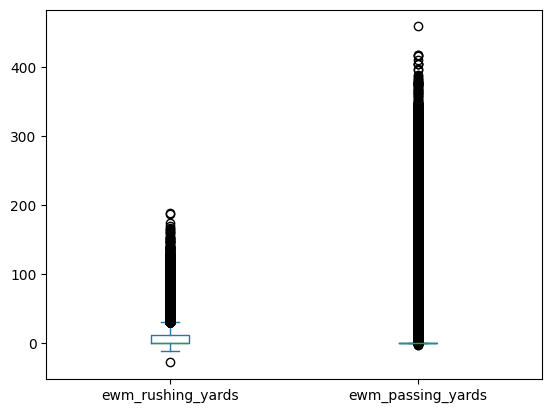

In [1094]:
df_merged[['ewm_rushing_yards', 'ewm_passing_yards']].plot.box()

<Axes: xlabel='ewm_attempts', ylabel='ewm_completions'>

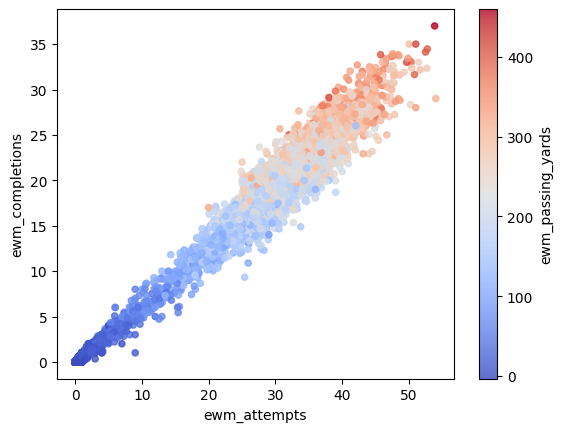

In [1095]:
df_merged.plot.scatter('ewm_attempts', 'ewm_completions', c='ewm_passing_yards', cmap='coolwarm', alpha=.8)

### Feature Selection

In [1096]:
# Train- und Test-Daten aufteilen
train_data = df_merged[df_merged['season'] < 2024]  # Daten für 2019-2023
test_data = df_merged[df_merged['season'] == 2024]  # Daten für 2024

# Features und Zielvariablen extrahieren
X_train = train_data.drop(columns=['fantasy_points'])  # 'target_column' = Zielvariable
y_train = train_data['fantasy_points']

X_test = test_data.loc[:, ~test_data.columns.str.startswith('ewm')]  # Filtert Spalten, die nicht mit 'ewm' starten
X_test = X_test.drop(columns=['fantasy_points'])  # Zielvariable entfernen
y_test = test_data['fantasy_points']



future_features = X_train.groupby('player_id').agg({
    'ewm_completions': 'last',
    'ewm_attempts': 'last', 
    'ewm_passing_yards': 'last',
    'ewm_carries': 'last', 
    'ewm_rushing_yards': 'last', 
    'ewm_receptions':'last', 
    'ewm_targets': 'last',
    'ewm_receiving_yards': 'last', 
    'ewm_fantasy_points': 'last', 
    'ewm_turnover': 'last',
    'ewm_rushing_pts': 'last', 
    'ewm_receiving_pts': 'last', 
    'ewm_passing_pts': 'last'
    }).reset_index()

X_test = pd.merge(X_test, future_features, on='player_id', how='left')

# Ergebnisse prüfen
print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

Train size: (26129, 26) (26129,)
Test size: (4384, 26) (4384,)


In [1097]:
X_train.columns

Index(['player_id', 'player_name', 'position', 'season', 'week', 'recent_team',
       'opponent_team', 'pick', 'home_team', 'roof', 'surface', 'wind', 'temp',
       'ewm_completions', 'ewm_attempts', 'ewm_passing_yards', 'ewm_carries',
       'ewm_rushing_yards', 'ewm_receptions', 'ewm_targets',
       'ewm_receiving_yards', 'ewm_fantasy_points', 'ewm_turnover',
       'ewm_rushing_pts', 'ewm_receiving_pts', 'ewm_passing_pts'],
      dtype='object')

In [1098]:
X_test.columns

Index(['player_id', 'player_name', 'position', 'season', 'week', 'recent_team',
       'opponent_team', 'pick', 'home_team', 'roof', 'surface', 'wind', 'temp',
       'ewm_completions', 'ewm_attempts', 'ewm_passing_yards', 'ewm_carries',
       'ewm_rushing_yards', 'ewm_receptions', 'ewm_targets',
       'ewm_receiving_yards', 'ewm_fantasy_points', 'ewm_turnover',
       'ewm_rushing_pts', 'ewm_receiving_pts', 'ewm_passing_pts'],
      dtype='object')

### Feature Encoding

In [1099]:
X_train['player_id'] = X_train['player_id'].str.replace('00-00', '').astype(int)

X_test['player_id'] = X_test['player_id'].str.replace('00-00', '').astype(int)

In [1100]:
X_train['home'] = (X_train['home_team'] == X_train['recent_team']).astype(int)
X_train = X_train.drop(columns=['home_team'])

X_test['home'] = (X_test['home_team'] == X_test['recent_team']).astype(int)
X_test = X_test.drop(columns=['home_team'])


In [1101]:
# One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=['player_name', 'position', 'recent_team', 'opponent_team', 'roof', 'surface'], drop_first=True)

X_test = pd.get_dummies(X_test, columns=['player_name', 'position', 'recent_team', 'opponent_team', 'roof', 'surface'], drop_first=True)

In [1102]:
# Fehlende Spalten in X_test hinzufügen und mit 0 auffüllen
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Überflüssige Spalten aus X_test entfernen und Reihenfolge anpassen
X_test = X_test[X_train.columns]

/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_20557/1460539993.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_20557/1460539993.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_20557/1460539993.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

In [1103]:
X_train

,player_id,season,week,pick,wind,temp,ewm_completions,ewm_attempts,ewm_passing_yards,ewm_carries,...,roof_dome,roof_open,roof_outdoors,surface_astroturf,surface_fieldturf,surface_grass,surface_grass,surface_matrixturf,surface_sportturf,surface_unknown
0,19596,2019,1,199.0,2.0,66.0,0.000000,0.000000,0.000000,0.000000,...,False,False,True,False,False,True,False,False,False,False
1,19596,2019,2,199.0,4.0,87.0,24.000000,36.000000,341.000000,0.000000,...,False,False,True,False,False,True,False,False,False,False
2,19596,2019,3,199.0,10.0,81.0,21.333333,30.666667,289.666667,1.333333,...,False,False,True,False,False,True,False,False,False,False
3,19596,2019,4,199.0,10.0,58.0,25.142857,37.142857,299.000000,1.714286,...,False,False,True,True,False,False,False,False,False,False
4,19596,2019,5,199.0,8.0,70.0,21.333333,38.133333,219.533333,2.400000,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29928,39165,2023,14,52.0,5.0,63.0,0.000000,0.000000,0.000000,15.518808,...,False,False,True,False,False,True,False,False,False,False
29929,39165,2023,15,52.0,2.0,46.0,0.000000,0.000000,0.000000,12.258608,...,False,False,True,False,True,False,False,False,False,False
29930,39165,2023,16,52.0,4.0,61.0,0.000000,0.000000,0.000000,8.128800,...,False,False,True,False,False,True,False,False,False,False
29931,39165,2023,17,52.0,4.0,47.0,0.000000,0.000000,0.000000,5.064213,...,False,False,True,False,True,False,False,False,False,False


In [1104]:
X_test

,player_id,season,week,pick,wind,temp,ewm_completions,ewm_attempts,ewm_passing_yards,ewm_carries,...,roof_dome,roof_open,roof_outdoors,surface_astroturf,surface_fieldturf,surface_grass,surface_grass,surface_matrixturf,surface_sportturf,surface_unknown
0,23459,2024,1,24.0,10.0,76.0,17.688388,27.875756,197.814136,2.938907,...,False,0,True,False,False,True,0,False,False,False
1,23459,2024,2,24.0,13.0,80.0,17.688388,27.875756,197.814136,2.938907,...,False,0,True,False,False,True,0,False,False,False
2,23459,2024,3,24.0,5.0,75.0,17.688388,27.875756,197.814136,2.938907,...,False,0,True,False,True,False,0,False,False,False
3,23459,2024,4,24.0,8.0,67.0,17.688388,27.875756,197.814136,2.938907,...,False,0,True,False,True,False,0,False,False,False
4,23459,2024,5,24.0,8.0,59.0,17.688388,27.875756,197.814136,2.938907,...,False,0,True,False,False,True,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,39921,2024,10,260.0,8.0,61.0,NaN,NaN,NaN,NaN,...,False,0,False,False,False,True,0,False,False,False
4380,39921,2024,12,260.0,5.0,45.0,NaN,NaN,NaN,NaN,...,False,0,True,False,True,False,0,False,False,False
4381,39921,2024,13,260.0,8.0,61.0,NaN,NaN,NaN,NaN,...,True,0,False,False,False,False,0,False,True,False
4382,39921,2024,14,260.0,8.0,61.0,NaN,NaN,NaN,NaN,...,False,0,False,False,False,True,0,False,False,False


### Feature Selection

In [1105]:
# X = df_merged.drop(columns='fantasy_points')
# X

In [1106]:
# y = df_merged['fantasy_points']
# y

### Data Splitting

In [1107]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# X_train.info()

### Feature Scaling

In [1108]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train

,player_id,season,week,pick,wind,temp,ewm_completions,ewm_attempts,ewm_passing_yards,ewm_carries,...,roof_dome,roof_open,roof_outdoors,surface_astroturf,surface_fieldturf,surface_grass,surface_grass,surface_matrixturf,surface_sportturf,surface_unknown
0,-4.766368,-1.475603,-1.605895,0.799711,-1.483091,0.433448,-0.332988,-0.335549,-0.331456,-0.554685,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
1,-4.766368,-1.475603,-1.413177,0.799711,-1.011420,1.931586,3.372625,3.277072,4.404468,-0.554685,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
2,-4.766368,-1.475603,-1.220458,0.799711,0.403593,1.503547,2.960891,2.741869,3.691533,-0.271225,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
3,-4.766368,-1.475603,-1.027739,0.799711,0.403593,-0.137271,3.549083,3.391758,3.821157,-0.190236,...,-0.452328,-0.170129,0.697467,4.152892,-0.548090,-0.961954,-0.277881,-0.268498,-0.220357,-0.178749
4,-4.766368,-1.475603,-0.835021,0.799711,-0.068078,0.718808,2.960891,3.491153,2.717497,-0.044457,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26124,1.743382,1.389845,0.899447,-0.798024,-0.775584,0.219428,-0.332988,-0.335549,-0.331456,2.744539,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
26125,1.743382,1.389845,1.092166,-0.798024,-1.483091,-0.993350,-0.332988,-0.335549,-0.331456,2.051436,...,-0.452328,-0.170129,0.697467,-0.240796,1.824516,-0.961954,-0.277881,-0.268498,-0.220357,-0.178749
26126,1.743382,1.389845,1.284884,-0.798024,-1.011420,0.076748,-0.332988,-0.335549,-0.331456,1.173459,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
26127,1.743382,1.389845,1.477603,-0.798024,-1.011420,-0.922010,-0.332988,-0.335549,-0.331456,0.521942,...,-0.452328,-0.170129,0.697467,-0.240796,1.824516,-0.961954,-0.277881,-0.268498,-0.220357,-0.178749


In [1109]:
X_train.columns

Index(['player_id', 'season', 'week', 'pick', 'wind', 'temp',
       'ewm_completions', 'ewm_attempts', 'ewm_passing_yards', 'ewm_carries',
       ...
       'roof_dome', 'roof_open', 'roof_outdoors', 'surface_astroturf',
       'surface_fieldturf', 'surface_grass', 'surface_grass ',
       'surface_matrixturf', 'surface_sportturf', 'surface_unknown'],
      dtype='object', length=1224)

In [1110]:
X_test.columns

Index(['player_id', 'season', 'week', 'pick', 'wind', 'temp',
       'ewm_completions', 'ewm_attempts', 'ewm_passing_yards', 'ewm_carries',
       ...
       'roof_dome', 'roof_open', 'roof_outdoors', 'surface_astroturf',
       'surface_fieldturf', 'surface_grass', 'surface_grass ',
       'surface_matrixturf', 'surface_sportturf', 'surface_unknown'],
      dtype='object', length=1224)

In [1111]:
# # Fehlende Spalten in X_test hinzufügen und mit 0 auffüllen
# for col in X_train.columns:
#     if col not in X_test.columns:
#         X_test[col] = 0

# # Überflüssige Spalten aus X_test entfernen und Reihenfolge anpassen
# X_test = X_test[X_train.columns]

In [1112]:
X_test = pd.DataFrame(scaler.transform(X_test),columns= X_test.columns)
X_test

,player_id,season,week,pick,wind,temp,ewm_completions,ewm_attempts,ewm_passing_yards,ewm_carries,...,roof_dome,roof_open,roof_outdoors,surface_astroturf,surface_fieldturf,surface_grass,surface_grass,surface_matrixturf,surface_sportturf,surface_unknown
0,-3.481317,2.106207,-1.605895,-1.102354,0.403593,1.146847,2.398109,2.461799,2.415854,0.070112,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
1,-3.481317,2.106207,-1.413177,-1.102354,1.111100,1.432207,2.398109,2.461799,2.415854,0.070112,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
2,-3.481317,2.106207,-1.220458,-1.102354,-0.775584,1.075507,2.398109,2.461799,2.415854,0.070112,...,-0.452328,-0.170129,0.697467,-0.240796,1.824516,-0.961954,-0.277881,-0.268498,-0.220357,-0.178749
3,-3.481317,2.106207,-1.027739,-1.102354,-0.068078,0.504788,2.398109,2.461799,2.415854,0.070112,...,-0.452328,-0.170129,0.697467,-0.240796,1.824516,-0.961954,-0.277881,-0.268498,-0.220357,-0.178749
4,-3.481317,2.106207,-0.835021,-1.102354,-0.068078,-0.065931,2.398109,2.461799,2.415854,0.070112,...,-0.452328,-0.170129,0.697467,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,1.994870,2.106207,0.128573,1.462717,-0.068078,0.076748,NaN,NaN,NaN,NaN,...,-0.452328,-0.170129,-1.433759,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749
4380,1.994870,2.106207,0.514010,1.462717,-0.775584,-1.064690,NaN,NaN,NaN,NaN,...,-0.452328,-0.170129,0.697467,-0.240796,1.824516,-0.961954,-0.277881,-0.268498,-0.220357,-0.178749
4381,1.994870,2.106207,0.706728,1.462717,-0.068078,0.076748,NaN,NaN,NaN,NaN,...,2.210783,-0.170129,-1.433759,-0.240796,-0.548090,-0.961954,-0.277881,-0.268498,4.538085,-0.178749
4382,1.994870,2.106207,0.899447,1.462717,-0.068078,0.076748,NaN,NaN,NaN,NaN,...,-0.452328,-0.170129,-1.433759,-0.240796,-0.548090,1.039551,-0.277881,-0.268498,-0.220357,-0.178749


# =====================================================
# Preprocessing abgeschlossen
# =====================================================

### Model Training

In [1113]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [1114]:
def plotResult(y_test,y_pred):
  plt.scatter(y_test, y_pred, s = 2)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
  plt.xlabel('actual value')
  plt.ylabel('predicted value')
  plt.show()

In [1115]:
print(len(y_test), len(xgb.predict(X_test)))

4384 4384


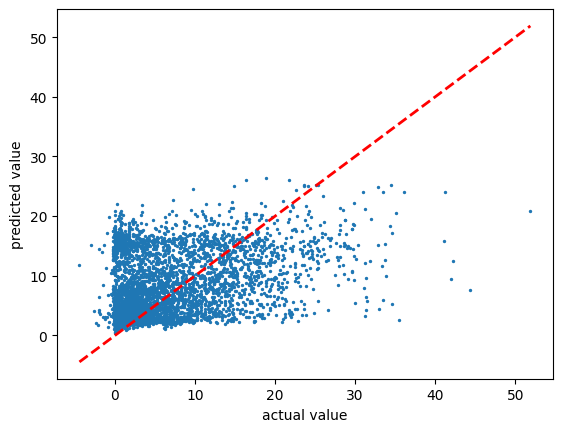

In [1116]:
plotResult(y_test, xgb.predict(X_test))

In [1117]:
xgb.score(X_test, y_test)

-0.06637001037597656

In [1118]:
mean_absolute_error(y_test, xgb.predict(X_test))


np.float32(5.403168)

In [1119]:
test_data.columns

Index(['player_id', 'player_name', 'position', 'season', 'week', 'recent_team',
       'opponent_team', 'fantasy_points', 'pick', 'home_team', 'roof',
       'surface', 'wind', 'temp', 'ewm_completions', 'ewm_attempts',
       'ewm_passing_yards', 'ewm_carries', 'ewm_rushing_yards',
       'ewm_receptions', 'ewm_targets', 'ewm_receiving_yards',
       'ewm_fantasy_points', 'ewm_turnover', 'ewm_rushing_pts',
       'ewm_receiving_pts', 'ewm_passing_pts'],
      dtype='object')

In [1120]:
results = pd.DataFrame({
    'player_name': test_data['player_name'],  # Spielername aus test_data
    'season': test_data['season'],           # Saison aus test_data
    'week': test_data['week'],               # Woche aus test_data
    'actual_fantasy_points': y_test,         # Tatsächliche Werte
    'predicted_fantasy_points': xgb.predict(X_test)       # Vorhergesagte Werte
})

# Exportiere das DataFrame als CSV-Datei
results.to_csv('fantasy_points_predictions.csv', index=False)
